<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
! pip install torchsummary

In [42]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from IPython.display import clear_output

from torchsummary import summary
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
# DATA_DIR = './thumbnails128x128/'
DATA_DIR = '../input/faces-generation/thumbnails128x128'

In [5]:
def get_dataloader(image_size, batch_size: int, stats: tuple):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

  dataloader = DataLoader(train_ds, 
                  batch_size, shuffle=True, 
                  num_workers=2, pin_memory=True)

  return dataloader

In [6]:
image_size = 128
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 
dataloader = get_dataloader(image_size, batch_size, stats)

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

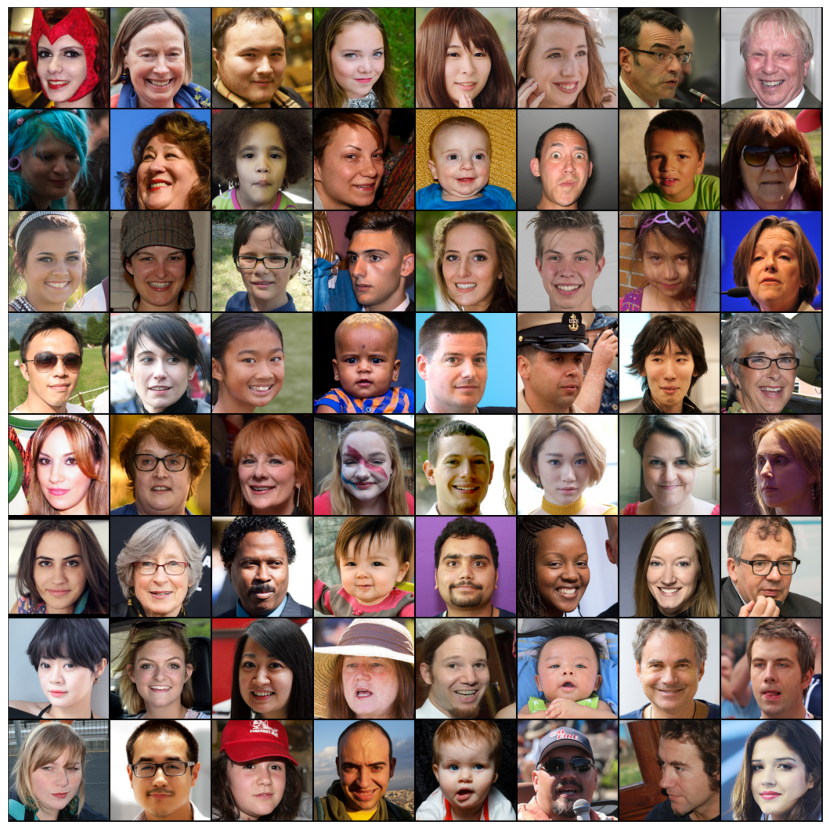

In [8]:
show_batch(dataloader)

In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
train_dl = DeviceDataLoader(dataloader, device)
device

device(type='cuda')

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [11]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4
    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid()
    )

In [12]:
latent_size = 128 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
    )

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [13]:
lr = 0.0001

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

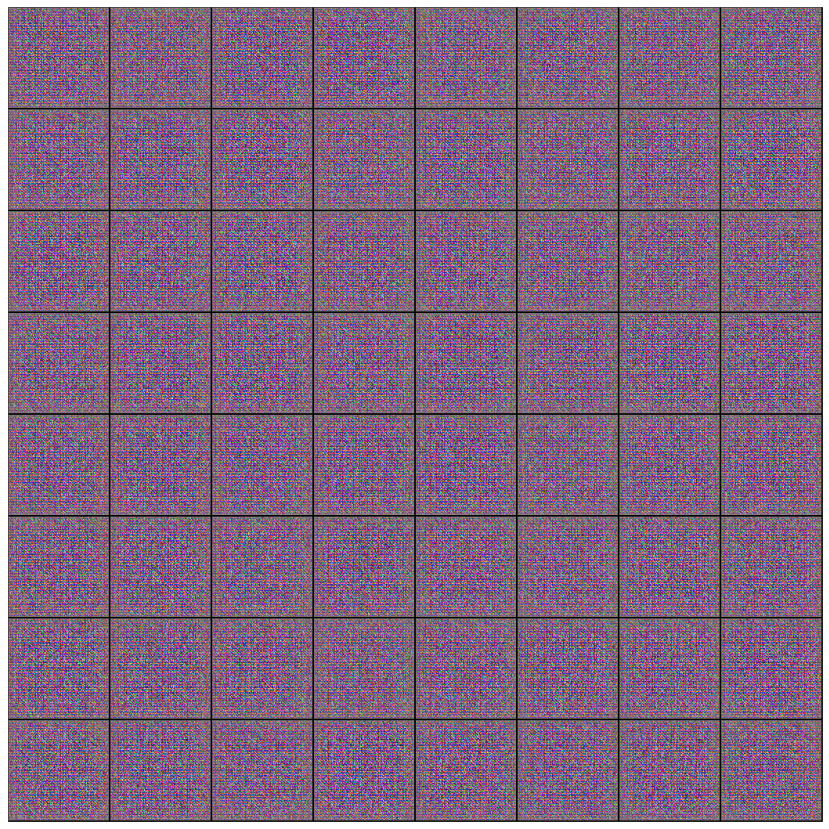

In [14]:
xb = torch.randn(batch_size, latent_size, 1, 1, device=device) 
fake_images = generator(xb).detach().cpu()
show_images(fake_images)

In [15]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [16]:
from collections.abc import Iterable, Callable
import matplotlib

In [17]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

class Plotter():
    def __init__(self, model: nn.Module, epochs: int,
                     figsize=(20,10)):
        super(Plotter, self).__init__()
        self.epochs = epochs
        self.figsize = figsize
        self.model = model
 
    def plot_info(self, history: list,
                    show_generated: bool=True, 
                    epoch: int=1):
        plt.figure(figsize=self.figsize)
        losses_g, losses_d, real_scores, fake_scores = history
        plt.suptitle('%d / %d - generator loss: %f discriminator loss: %f' % (epoch+1, 
                                                                        self.epochs, losses_g[-1], losses_d[-1]))
        plt.subplot(2, 2, 1)
        plt.plot(losses_d, color='r')
        plt.title('Discriminator loss', fontdict={'fontsize': 10})
        plt.legend(['discriminator'])
        plt.subplot(2, 2, 2)
        plt.plot(losses_g, color='b')
        plt.title('Generator loss', fontdict={'fontsize': 10})
        plt.legend(['generator'])

        plt.subplot(2, 2, 3)
        plt.plot(real_scores, color='r')
        plt.title('Real score', fontdict={'fontsize': 10})
        plt.legend(['real'])
        plt.subplot(2, 2, 4)
        plt.plot(fake_scores, color='b')
        plt.title('Generated score', fontdict={'fontsize': 10})
        plt.legend(['generated'])
        plt.show()
        if show_generated:
            
            fixed_latent = torch.randn(20, latent_size, 1, 1, device=device)
            model['generator'].eval()
            fake_images = model['generator'](fixed_latent)
            fig, ax = plt.subplots(figsize=self.figsize)
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(make_grid(fake_images.cpu().detach().clip(0,1), nrow=10).permute(1, 2, 0))

In [18]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    plotter = Plotter(model, epochs+start_idx)
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }


    log_template = "Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}"
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        with tqdm(train_dl, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            for real_images, _ in tepoch:
                # Train discriminator
                # Clear discriminator gradients
                optimizer["discriminator"].zero_grad()

                # Pass real images through discriminator
                real_preds = model["discriminator"](real_images)
                real_targets = torch.ones(real_images.size(0), 1, device=device)
                real_loss = criterion["discriminator"](real_preds, real_targets)
                cur_real_score = torch.mean(real_preds).item()
                
                # Generate fake images
                latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
                fake_images = model["generator"](latent)

                # Pass fake images through discriminator
                fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
                fake_preds = model["discriminator"](fake_images)
                fake_loss = criterion["discriminator"](fake_preds, fake_targets)
                cur_fake_score = torch.mean(fake_preds).item()

                real_score_per_epoch.append(cur_real_score)
                fake_score_per_epoch.append(cur_fake_score)

                # Update discriminator weights
                loss_d = real_loss + fake_loss
                loss_d.backward()
                optimizer["discriminator"].step()
                loss_d_per_epoch.append(loss_d.item())


                # Train generator
                # Clear generator gradients
                optimizer["generator"].zero_grad()
                
                # Generate fake images
                latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
                fake_images = model["generator"](latent)
                
                # Try to fool the discriminator
                preds = model["discriminator"](fake_images)
                targets = torch.ones(batch_size, 1, device=device)
                loss_g = criterion["generator"](preds, targets)
                
                # Update generator weights
                loss_g.backward()
                optimizer["generator"].step()
                loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        clear_output()
        tqdm.write(log_template.format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        plotter.plot_info((losses_g, losses_d, 
                                real_scores, fake_scores), epoch=epoch,
                                show_generated=True)
        tepoch.update(1)
        # Save generated images
        if epoch == epochs - 1:
            fixed_latent = torch.randn(20, latent_size, 1, 1, device=device)
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

Epoch [25/25], loss_g: 5.4503, loss_d: 0.1801, real_score: 0.9470, fake_score: 0.0524


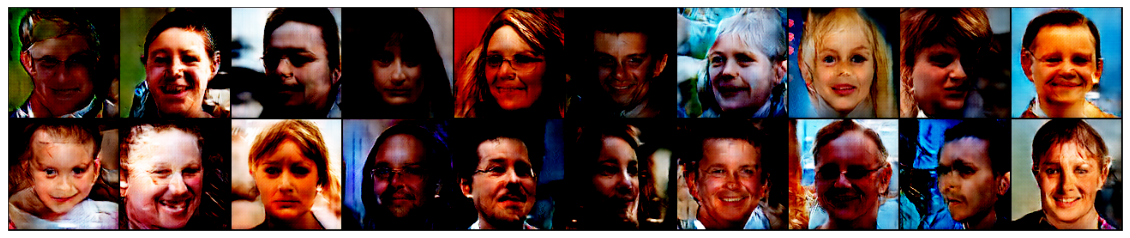

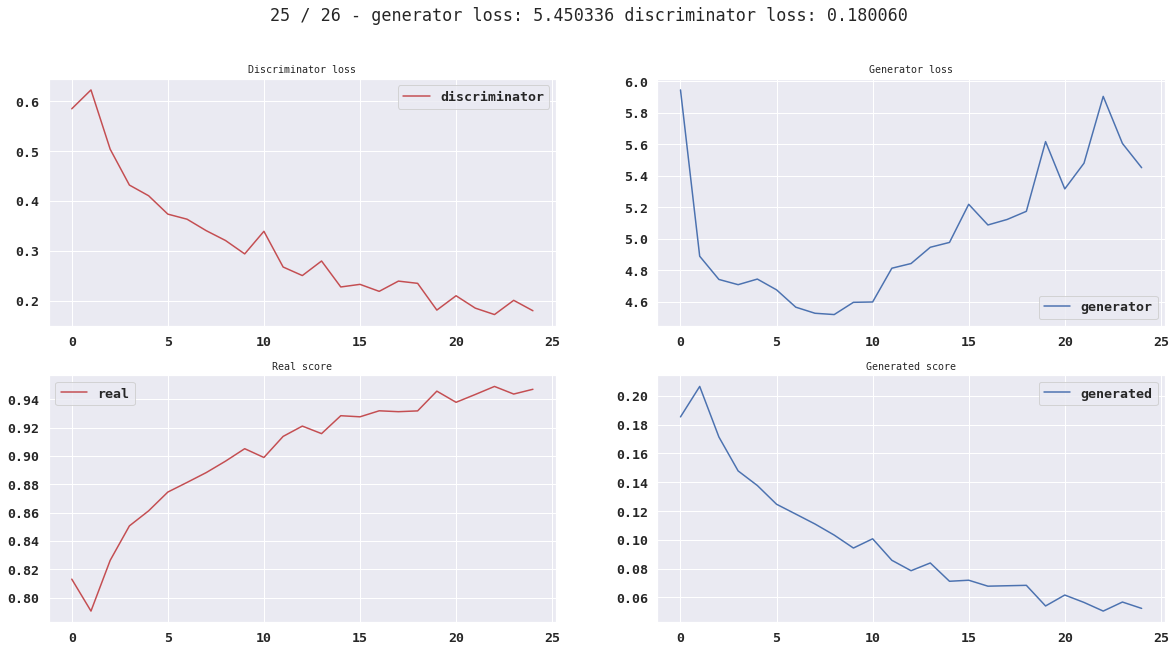

Saving generated-images-0025.png


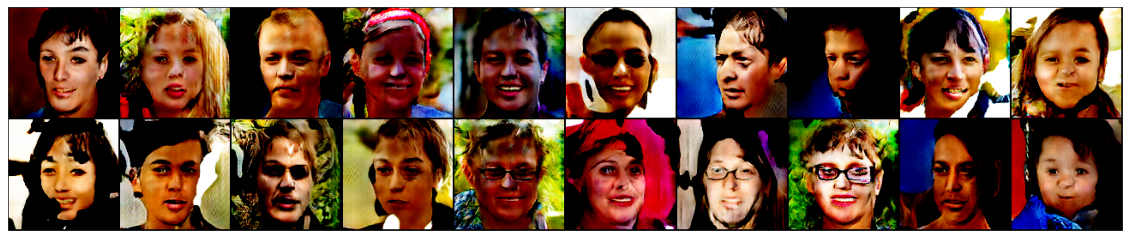

In [19]:
history = fit(model, criterion, 25, lr)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Поведение графиков чуть более резкое, чем на лекции, но общий тренд сохранен.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [20]:
n_images = 16

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [21]:
def show_images(generated):
  fig, ax = plt.subplots(figsize=(15, 15))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(generated.cpu().detach(), nrow=8).permute(1, 2, 0).clip(0,1))

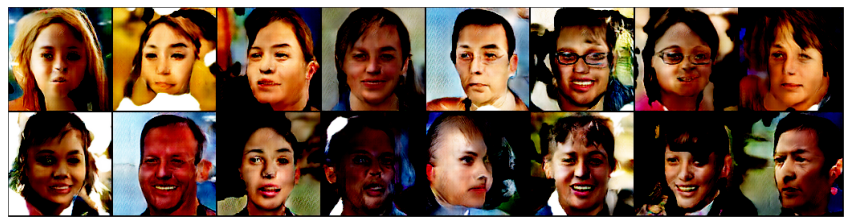

In [22]:
show_images(fake_images)

Как вам качество получившихся изображений?

Много артефактов, но это сильно лучше, чем качество генерации автоэнкодером.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [2]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

In [28]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

subset = torch.utils.data.Subset(train_ds, 
                        np.random.choice(len(train_ds), len(train_ds) // 10, replace=False))
dataloader = DataLoader(subset, 
                  batch_size, shuffle=True)

In [34]:
X, y = pd.DataFrame(), pd.DataFrame()
with tqdm(dataloader, unit="batch") as tqpb:
    for X_batch, _ in tqpb:
        X_batch = nn.Flatten()(X_batch).numpy()
        y_batch = torch.ones(X_batch.shape[0]).numpy()
        X = pd.concat([X, pd.DataFrame(X_batch)])
        y = pd.concat([y, pd.DataFrame(y_batch)])

  0%|          | 0/103 [00:00<?, ?batch/s]

In [35]:
X.shape, y.shape

((6553, 49152), (6553, 1))

In [36]:
for X_batch, _ in tqdm(dataloader):
    fixed_latent = torch.randn(X_batch.shape[0], latent_size, 1, 1, device=device)
    fake_images = model["generator"](fixed_latent)
    fake_images = nn.Flatten()(fake_images).detach().cpu().numpy()
    y_batch = torch.zeros(X_batch.shape[0]).numpy()


    X = pd.concat([X, pd.DataFrame(fake_images)])
    del fake_images
    del fixed_latent
    y = pd.concat([y, pd.DataFrame(y_batch)])

  0%|          | 0/103 [00:00<?, ?it/s]

In [37]:
X.shape, y.shape

((13106, 49152), (13106, 1))

In [43]:
X.to_csv('data_wi.csv', index=False)
y.to_csv('targets_wi.csv', index=False)

In [3]:
from IPython.display import clear_output

In [4]:
X = pd.DataFrame()
i=1
for chunk in pd.read_csv("./data_wi.csv", chunksize=150):
    print(f"chunk {i} processing...")
    X = pd.concat([X, chunk])
    i += 1
    clear_output(wait=True)

chunk 88 processing...


In [7]:
y = pd.read_csv('targets_wi.csv')

In [22]:
resized_X = pd.concat([X.head(200), X.tail(200)])
resized_y = pd.concat([y.head(200), y.tail(200)])

In [23]:
resized_X.shape, resized_y.shape

((400, 49152), (400, 1))

In [46]:
def leave_one_out_classifier(X: pd.DataFrame, y: pd.DataFrame):
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    scores = []
    for train, test in tqdm(loo.split(X), total=len(list(loo.split(X)))):
        X_train, y_train = X.iloc[train, :], y.iloc[train, :]
        X_test, y_test = X.iloc[test, :], y.iloc[test, :]
        scores.append(
            accuracy_score(y_test, 
                           KNeighborsClassifier(n_neighbors=1).fit(
                               X_train, y_train.values.squeeze()).predict(X_test))
        )
    return scores

scores = leave_one_out_classifier(resized_X, resized_y)
print(np.array(scores).mean())

  0%|          | 0/400 [00:00<?, ?it/s]

0.6325


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Не очень хороший результат accuracy говорит о том, что отличить сгенерированные данные от реальных непросто. Идеальный accuracy = 0.5. 

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [45]:
from sklearn.manifold import TSNE

Прокомментируйте получившийся результат:

In [40]:
def tsne_plot(images: pd.DataFrame, classes: Iterable, figsize: tuple=(8,8)):
    tsne = TSNE(n_components=2)
    latent = tsne.fit_transform(images)
    plt.figure(figsize=figsize)
    sns.scatterplot(x=latent[:,0], y=latent[:,1], hue=classes, 
                    palette=sns.color_palette('Paired', 2))
    plt.show()

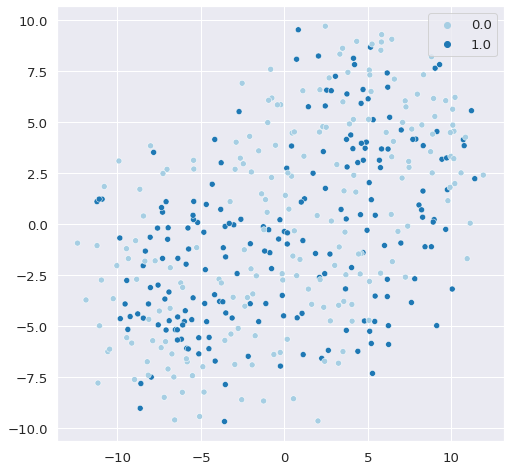

In [44]:
tsne_plot(resized_X, resized_y.values.squeeze())

Сгенерированные данные не так уж и отличаются от реальных в латентном пространстве.